### SVM Classsifier

In [1]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import sys
import warnings

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from scipy import stats

#### Load Data

In [2]:
data = pd.read_csv('processed_data/combined.csv')
data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0023001,5309.7,434.0,12642.4,65841.3,8371.4,4888.4,6444.8,1853.9,683.8,...,14174.0,1498.0,3142.0,1226.0,8238.0,1270732.0,0.0,9.33,Control,NaN
1,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,NaN
2,sub-2427434,4891.9,423.1,11186.9,55092.0,7097.7,4590.8,6129.0,1644.6,509.2,...,15959.0,1767.0,2944.0,1245.0,7786.0,1089479.0,1.0,8.08,Control,NaN
3,sub-2230510,2535.1,543.5,12772.8,56887.6,6487.1,3495.2,5464.6,1604.3,529.8,...,5974.0,1634.0,1771.0,968.0,5007.0,970763.0,0.0,9.17,ADHD,NaN
4,sub-0023006,4477.6,378.9,11991.9,62007.1,6189.8,3987.9,5120.0,1498.6,537.6,...,10689.0,1231.0,2496.0,1124.0,7411.0,1045207.0,1.0,9.25,Control,NaN


In [3]:
# Update adhd_binary column based on diagnosis
data['adhd_binary'] = data['diagnosis'].apply(lambda x: 1 if x == 'ADHD' else 0)
data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary
0,sub-0023001,5309.7,434.0,12642.4,65841.3,8371.4,4888.4,6444.8,1853.9,683.8,...,14174.0,1498.0,3142.0,1226.0,8238.0,1270732.0,0.0,9.33,Control,0
1,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,11197.0,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,1
2,sub-2427434,4891.9,423.1,11186.9,55092.0,7097.7,4590.8,6129.0,1644.6,509.2,...,15959.0,1767.0,2944.0,1245.0,7786.0,1089479.0,1.0,8.08,Control,0
3,sub-2230510,2535.1,543.5,12772.8,56887.6,6487.1,3495.2,5464.6,1604.3,529.8,...,5974.0,1634.0,1771.0,968.0,5007.0,970763.0,0.0,9.17,ADHD,1
4,sub-0023006,4477.6,378.9,11991.9,62007.1,6189.8,3987.9,5120.0,1498.6,537.6,...,10689.0,1231.0,2496.0,1124.0,7411.0,1045207.0,1.0,9.25,Control,0


In [4]:
# First, let's check which columns have NaN values
print("NaN count in each column:")
nan_counts = data.isna().sum()
print(nan_counts)

NaN count in each column:
subject_id                      0
Left-Lateral-Ventricle          0
Left-Inf-Lat-Vent               0
Left-Cerebellum-White-Matter    0
Left-Cerebellum-Cortex          0
                               ..
rh_insula_volume                0
gender                          0
age                             0
diagnosis                       0
adhd_binary                     0
Length: 285, dtype: int64


In [5]:
# Identify columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
print(f"\nColumns containing NaN values: {columns_with_nans}")


Columns containing NaN values: ['eTIV']


In [6]:
fields_to_drop = ['subject_id', 'gender', 'age', 'diagnosis'] + columns_with_nans
clean_data = data.drop(columns = fields_to_drop)
X = clean_data.drop(columns = 'adhd_binary')
y = clean_data['adhd_binary']

In [7]:
X.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
0,5309.7,434.0,12642.4,65841.3,8371.4,4888.4,6444.8,1853.9,683.8,1859.3,...,20526.0,25740.0,15473.0,12755.0,14174.0,1498.0,3142.0,1226.0,8238.0,1270732.0
1,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,1305.9,...,18757.0,24884.0,14151.0,12134.0,11197.0,1626.0,2100.0,875.0,5565.0,992979.0
2,4891.9,423.1,11186.9,55092.0,7097.7,4590.8,6129.0,1644.6,509.2,1607.3,...,19620.0,26584.0,14714.0,14746.0,15959.0,1767.0,2944.0,1245.0,7786.0,1089479.0
3,2535.1,543.5,12772.8,56887.6,6487.1,3495.2,5464.6,1604.3,529.8,2136.2,...,24036.0,27398.0,10572.0,10603.0,5974.0,1634.0,1771.0,968.0,5007.0,970763.0
4,4477.6,378.9,11991.9,62007.1,6189.8,3987.9,5120.0,1498.6,537.6,1586.2,...,14496.0,23827.0,14284.0,12780.0,10689.0,1231.0,2496.0,1124.0,7411.0,1045207.0


In [8]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: adhd_binary, dtype: int64

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Create SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)

In [12]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy scores: [0.75409836 0.63934426 0.6557377  0.7        0.65      ]
Mean CV accuracy: 0.6798 ± 0.0425


In [13]:
# Train the model on the full training set
svm.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [14]:
# Make predictions on test set
y_pred = svm.predict(X_test_scaled)
y_pred_prob = svm.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for ROC curve

In [15]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Print performance metrics
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Performance Metrics:
Accuracy: 0.7405
Precision: 0.7750
Recall: 0.5536
F1 Score: 0.6458
AUC: 0.8431


In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[66  9]
 [25 31]]


In [17]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        75
           1       0.78      0.55      0.65        56

    accuracy                           0.74       131
   macro avg       0.75      0.72      0.72       131
weighted avg       0.75      0.74      0.73       131



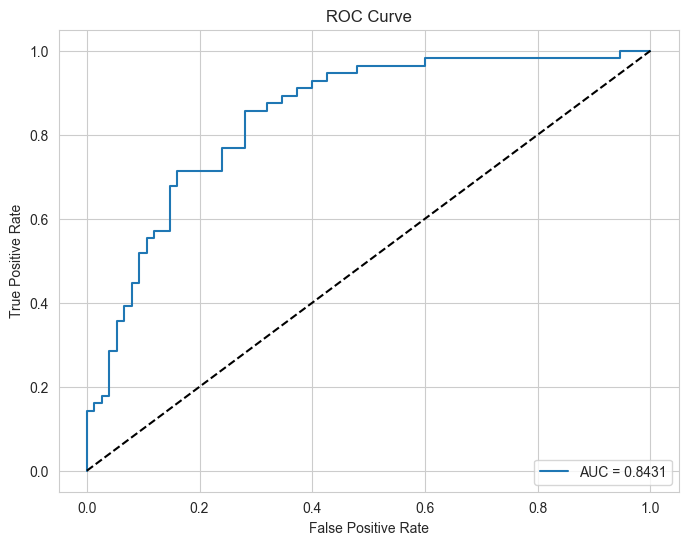

In [18]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()